<a href="https://colab.research.google.com/github/YiqunLiu/MIRcourse/blob/master/Lecture1_step1_LowLevelDescriptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lecture 1: Low level descriptors

In this example, you will be implementing some of the low level feature extraction functions and applying those in analysis of a tiny dataset. You will be implementing four low level features: energy, zero-crossing rate, spectral centroid and spectral flatness.

A low level feature is computed on "frame level" which basically refers to chopping the signal into small frames (let say of duration 20 milliseconds) and extracting a feature value for each frame. That means the number of resulting feature values will be equal to the number of frames. That may be too many for many applications/tasks. Often we prefer to summarize all these feature values by simply computing a few descriptive statictical parameters (such as the mean, median, standard deviations, etc.). These would be referred as the global features since they represent the global distribution of the low-level feature for the whole recording. 

You are expected to both implement low-level feature extraction and the statistical/global parameters computation, in two different functions: *compute_low_level_features* , *compute_global_features*

Your contribution is expected in implementing parts of functions in the second cell. Please do not modify other parts of the code. We will go through it quickly in the lecture.

Your parts are marked with labels: #Your code starts here ... #Your code ends here

------
The code will process data in the 'data/freesound' folder. To form a larger dataset for this example, use the FreeSound example: https://github.com/MTG/MIRCourse/blob/master/notebooks/DownloadDataFromFreeSound_noToken.ipynb with query strings:'kiss' and 'whistle', setting a larger value for maxNumFilePerInst. The tiny set was created by setting maxNumFilePerInst=10 and further manually removing files which contained other sounds than 'kiss' or 'whistle'

See [Lecture1_step1_solution](Lecture1_step1_solution.ipynb) for an implementation

In [0]:
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia

     |████████████████████████████████| 11.7MB 2.8MB/s 


In [0]:
#Package imports
import os
import sys
import numpy as np
from scipy.fftpack import fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
import essentia.standard as ess

%matplotlib inline

#---Functions already implemented (do not modify contents of this cell) ---

#Container for analysis parameters
class AnalysisParams:
    def __init__(self, windowSize, hopSize, windowFunction, fftN, fs):
        '''
        windowSize: milliseconds,
        hopSize: milliseconds,
        windowFunction: str ('blackman','hanning',...)
        fftN: int
        '''
        self.windowSize = windowSize
        self.hopSize = hopSize
        self.windowFunction = windowFunction
        self.fftN=fftN
        self.fs=fs

#Function for creating data container dictionary for a sound file
def initiate_data_for_file(file, root):
    '''Forming the data structure for file
    Parameters
    ----------
    file,root : str
        File name and path info
    
    Returns
    -------
    fileData : dict
        Dictionary containing all info and data for the file
    ''' 
    fileData = dict(); fileData['name'] = file; fileData['path'] = root;
    #Low level(LL) features
    fileData['NRG'] = []; fileData['zcr'] = [];#time domain features
    fileData['specCentroid'] = []; fileData['specFlatness'] = [];#frequency domain features
    
    return fileData

#Plotting function for checking feature extraction 
def plot_features_with_wave(fileData, params, featureNames):
    '''Plotting frame based features together with the wave signal (all normalized to unit ampl.)
    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    params : instance of AnalysisParams
        Analysis parameters
    featureNames : list[str]
        List of names of the features to be plotted
    '''
    #Reading the wave file
    x = ess.MonoLoader(filename = os.path.join(fileData['path'], fileData['name']), sampleRate = params.fs)()
    #Normalize maximum amplitude to 1
    x = x / np.max(np.abs(x))
    t = np.arange(x.size) / float(params.fs)
    
    plt.figure(figsize=(12, 4))
    plt.plot(t,x, label = 'Sound signal')
    colorCodes = 'rcmgky'
    for i, featureName in enumerate(featureNames):
        featData = fileData[featureName]
        featData = featData / np.max(np.abs(featData))#Normalize for plotting purposes
        if len(featData) > 1:
            xax = np.arange(featData.size) * (x.size / featData.size) / float(params.fs)
            plt.plot(xax, featData,colorCodes[i]+'.',label = featureName + '-normalized')
    plt.ylabel('amplitude')
    plt.axis('tight')
    plt.legend(loc = 'best')
    plt.show()


### You will be implementing extractors for the following low-level features

Definitions of the low-level features

Energy:
\begin{equation}
energy = \sum_{n = 0}^{N-1} |x[n]|^2
\end{equation}

Zero crossing rate:
$$
zcr = \frac{1}{N-1} \sum_{n=1}^{N-1} | sign(x[n]) - sign(x[n-1]) |
$$
with the signum function is defined as:
$$
sign(x[n])  = \begin{cases}
  1, & \text{ if } x[n] > 0\\ 
  0, & \text{ if } x[n] = 0\\ 
  -1,&\text{ if } x[n] < 0
\end{cases}
$$
Spectral centroid:
$$
spectralCentroid = \frac{\sum_{k=0}^{N-1} k|X[k]|}{\sum_{k=0}^{N-1} |X[k]|}
$$
Spectral flatness:
$$
spectralFlatness = \frac{ (\prod_{k=0}^{N-1}{X(k)})^{^{1/N}}}{\frac{1}{N}\sum_{k=0}^{N-1} |X[k]|}
$$
or simplified dB form:
$$
spectralFlatnessdB = 10 \frac{1}{N} \sum_{ k = 0 }^{ N-1 } (log_{10} X[k] - log_{10} \mu)
$$
where X is the Discrete Fourier Transform of the time domain signal x (n time index, k frequency bin index) and $\mu$ refers to mean of X.

$$\mu = \frac{1}{N}\sum_{n=0}^{N-1} X[k] $$


### Your task is here:

Your parts are marked with labels: #Your code starts here ... #Your code ends here

In [0]:
#Focus of this notebook
def compute_low_level_features(fileData, params):
    '''Computation of the low-level features
    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    params : instance of AnalysisParams
        Analysis parameters
    Modifies
    -------
    fileData 
    '''
    #Reading the wave file'std_'+feature
    x = ess.MonoLoader(filename = os.path.join(fileData['path'], fileData['name']), sampleRate = params.fs)()
    #Normalize maximum amplitude to 1
    x = x / np.max(np.abs(x))
    #Windowing (first converting from msec to number of samples)
    windowSize = round(params.fs*params.windowSize / 1000)
    hopSize = round(params.fs*params.hopSize / 1000)
    windowFunction = params.windowFunction
    w = get_window(windowFunction, windowSize)
    startIndexes = np.arange(0, x.size-windowSize,hopSize, dtype=int)
    numWindows = startIndexes.size
    
    #Initializing feature arrays
    NRG = np.zeros_like(startIndexes,dtype = float)#initializing the array for keeping energy values
    zcr = np.zeros_like(startIndexes,dtype = float)#initializing the array for zero-crossing rate
    specCentroid = np.zeros_like(startIndexes,dtype = float)#initializing the array for keeping energy values
    specFlatness = np.zeros_like(startIndexes,dtype = float)#initializing the array for zero-crossing rate

    #Your code starts here
    #Implement actual windowing and feature extraction here
    
    for i in range(numWindows):
        Frame = x[startIndexes[i]:startIndexes[i] + windowSize]
        windowedFrame = Frame * w
        
        # Energy:
        NRG[i] = np.sum(np.square(windowedFrame))
        
        # Zero crossing rate:
        sign_x = np.sign(windowedFrame)
        zcr[i] = np.sum(np.abs(sign_x[1:]-sign_x[:-1])) / (windowSize - 1)

        # Spectum:
        FFT = ess.FFT()
        if windowedFrame.size % 2 == 1: #essentia FFT can only be computed on frames which size is even and non zero
            windowedFrame = windowedFrame[:-1]
        X = FFT(windowedFrame)

        # Spectral centroid:
        #specCentroid[i] = np.sum(np.arange(X.size()) * np.abs(X)) / np.sum(np.abs(X))
        specCentroid[i] = np.dot(np.arange(X.size), np.abs(X)) / np.sum(np.abs(X))

        # Spectral flatness:
        mu = np.mean(X)
        specFlatness[i] = 10.0 / X.size * np.sum(np.log10(X)-np.log10(mu))
        
    #Your code ends here

    fileData['NRG'] = NRG;
    fileData['zcr'] = zcr;
    fileData['specCentroid'] = specCentroid;
    fileData['specFlatness'] = specFlatness;

def compute_global_features(fileData, NRGthreshold = 0.05):
    '''Computation of the global features from low-level features
    An energy threshold (NRGthres*maxEnergy) is applied to exclude features from silence regions

    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    NRGthresPerc: float
        Energy threshold defined as ratio to maximum energy. Ex: 0.05 corresponds to 5%
    Modifies
    -------
    fileData 
    '''
    #Your code starts here
    #To remove from feature data those coming from silence regions, use an energy threshold (%5 of the max) 
    
    NRG = fileData['NRG']
    if NRG.size == 0: # some NRG are empty that have no max value 
        NRG = ([0])
    zcr = fileData['zcr']
    specCentroid = fileData['specCentroid']
    specFlatness = fileData['specFlatness']
    threshold = np.max(NRG) * NRGthreshold
    numFrame = len(NRG)
    NRG_keep = []
    zcr_keep = []
    specCentroid_keep = []
    specFlatness_keep = []
    
    for i in range(numFrame):
        if NRG[i] > threshold:
            NRG_keep.append(NRG[i])
            zcr_keep.append(zcr[i])
            specCentroid_keep.append(specCentroid[i])
            specFlatness_keep.append(specFlatness[i])
    fileData['std_NRG'] = np.std(NRG_keep)
    fileData['mean_NRG'] = np.mean(NRG_keep)
    fileData['std_zcr'] = np.std(zcr_keep)
    fileData['mean_zcr'] = np.mean(zcr_keep)
    fileData['std_specCentroid'] = np.std(specCentroid_keep)
    fileData['mean_specCentroid'] = np.mean(specCentroid_keep)
    fileData['std_specFlatness'] = np.std(specFlatness_keep)
    fileData['mean_specFlatness'] = np.mean(specFlatness_keep)
    """
    fileData['std_NRG'] = np.std(NRG)
    fileData['mean_NRG'] = np.mean(NRG)
    fileData['std_zcr'] = np.std(zcr)
    fileData['mean_zcr'] = np.mean(zcr)
    fileData['std_specCentroid'] = np.std(specCentroid)
    fileData['mean_specCentroid'] = np.mean(specCentroid)
    fileData['std_specFlatness'] = np.std(specFlatness)
    fileData['mean_specFlatness'] = np.mean(specFlatness)
    """
    #Your code ends here

### Running extractors for files in the folder

In [0]:
#This cell downloads the mridangam dataset
import urllib.request
import zipfile
import os, sys,shutil

url = 'https://zenodo.org/record/1265188/files/mridangam_stroke_1.0.zip'
filename = 'dataset.zip'
#targetDir = ''
urllib.request.urlretrieve(url,filename)#Downlad the zip
zip_ref = zipfile.ZipFile(filename, 'r')#Open the zip
zip_ref.extractall()#Unzip
zip_ref.close()
os.remove(filename)#Removing the zip file

In [0]:
#Setting analysis parameters
# windowSize: milliseconds,hopSize: milliseconds,windowFunction: str ('blackman','hanning',...),fftN: int
params = AnalysisParams(30, 10, 'blackman', 2048, 44100)
soundsDir = segments_dir

#Collecting wave file names in a folder(and its subfolders)
classFiles = dict()
for root, dirs, files in os.walk('mridangam_stroke_1.0'):
    for file in files:
        if file.endswith('.wav'):
            auxiliary = file.split('__')[-1]
            soundClass = auxiliary.split('-')[0]
            if(str.isalpha(soundClass)):
                fileData = initiate_data_for_file(file, root)            
                files4soundClass = classFiles.get(soundClass)
                if files4soundClass == None:
                    files4soundClass = [fileData]
                else:
                    files4soundClass.append(fileData)
                classFiles[soundClass] = files4soundClass

#Feature extraction for all files of each soundClass
for soundClass, filesData in classFiles.items():
    for fileInd in range(len(filesData)):
        compute_low_level_features(classFiles[soundClass][fileInd], params)
        compute_global_features(classFiles[soundClass][fileInd])

#Sound classes list
soundClasses = list(classFiles.keys())
print('soundClasses in this dataset: ',soundClasses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


soundClasses in this dataset:  ['thi', 'tham', 'tha', 'dhin', 'cha', 'ta', 'thom', 'dheem', 'num', 'bheem']


**Let's create example plots of the extracted features**

In [0]:
#Plotting features for some samples: one sample for each soundClass
for soundClass in soundClasses:
    plot_features_with_wave(classFiles[soundClass][0],params,['NRG','zcr','specCentroid','specFlatness'])

Look's ok but are we going to keep the features extracted at the silence regions/frames? Better not! 

In global feature extraction, let's use an energy threshold to decide if a frame is silence or not, and only keep feature values for non-silence frames.

### Global features

The global features are representations of each sample file with a few statictical parameters. At this point we will be plotting samples(sound files) on global feature spaces (2 dimensional for practical purposes) with the aim of observing if samples from different classes are closely located(hence seperable) in feature spaces.

List of global features:  ['std_zcr', 'std_specCentroid', 'mean_NRG', 'std_NRG', 'mean_specCentroid', 'mean_zcr', 'std_specFlatness', 'mean_specFlatness']


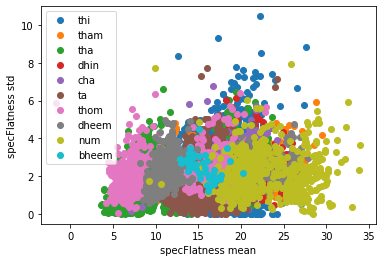

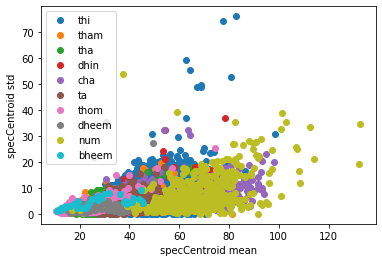

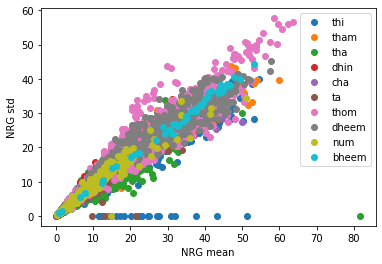

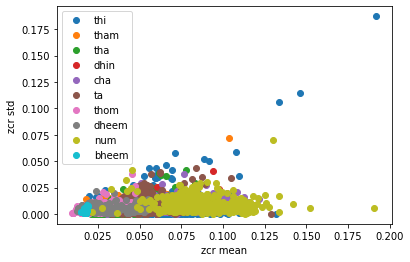

In [0]:
#Collecting global features data
features = list(classFiles[soundClasses[0]][0].keys())
globalFeats = set()
globalFeatsData = dict()#dictionary including dictionaries soundClass->feature->data
for soundClass in soundClasses:
    featuresData = dict()
    for feature in features:
        #Collect only global features
        if ('std_' in feature) or ('mean_' in feature):
            globalFeats.add(feature)#gathering list of global features
            data=[]
            for fileInd in range(len(classFiles[soundClass])):
                data.append(classFiles[soundClass][fileInd][feature])
            featuresData[feature] = data
    globalFeatsData[soundClass] = featuresData
globalFeats = list(globalFeats)
print('List of global features: ',globalFeats)
#Plotting samples on global feature spaces
for feature in ['specFlatness','specCentroid','NRG','zcr']:
    stroke1 = 'thi'
    stroke2 = 'tham'
    stroke3 = 'tha'
    stroke4 = 'dhin'
    stroke5 = 'cha'
    stroke6 = 'ta'
    stroke7 = 'thom'
    stroke8 = 'dheem'
    stroke9 = 'num'
    stroke10 = 'bheem'
    plt.plot(globalFeatsData[stroke1]['mean_' + feature],globalFeatsData[stroke1]['std_' + feature],'o',label = stroke1)
    plt.plot(globalFeatsData[stroke2]['mean_' + feature],globalFeatsData[stroke2]['std_' + feature],'o',label = stroke2)
    plt.plot(globalFeatsData[stroke3]['mean_' + feature],globalFeatsData[stroke3]['std_' + feature],'o',label = stroke3)
    plt.plot(globalFeatsData[stroke4]['mean_' + feature],globalFeatsData[stroke4]['std_' + feature],'o',label = stroke4)
    plt.plot(globalFeatsData[stroke5]['mean_' + feature],globalFeatsData[stroke5]['std_' + feature],'o',label = stroke5)
    plt.plot(globalFeatsData[stroke6]['mean_' + feature],globalFeatsData[stroke6]['std_' + feature],'o',label = stroke6)
    plt.plot(globalFeatsData[stroke7]['mean_' + feature],globalFeatsData[stroke7]['std_' + feature],'o',label = stroke7)
    plt.plot(globalFeatsData[stroke8]['mean_' + feature],globalFeatsData[stroke8]['std_' + feature],'o',label = stroke8)
    plt.plot(globalFeatsData[stroke9]['mean_' + feature],globalFeatsData[stroke9]['std_' + feature],'o',label = stroke9)
    plt.plot(globalFeatsData[stroke10]['mean_' + feature],globalFeatsData[stroke10]['std_' + feature],'o',label = stroke10)
    plt.legend(loc = 'best')
    plt.xlabel(feature + ' mean')
    plt.ylabel(feature + ' std')
    plt.show()

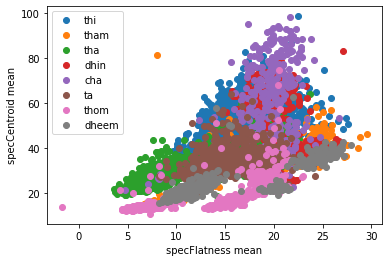

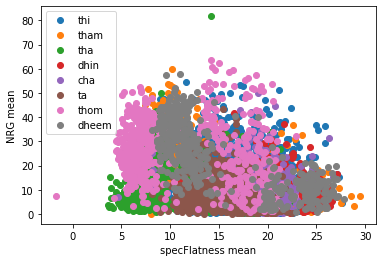

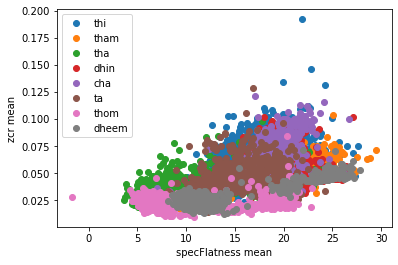

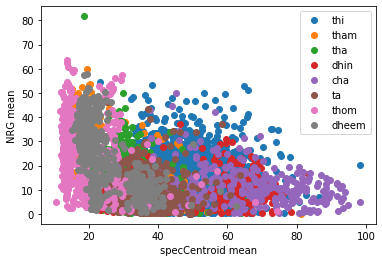

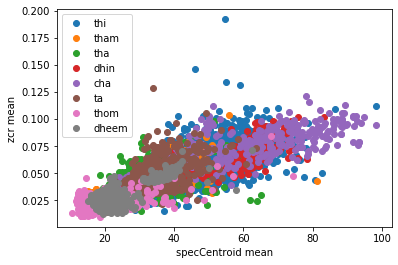

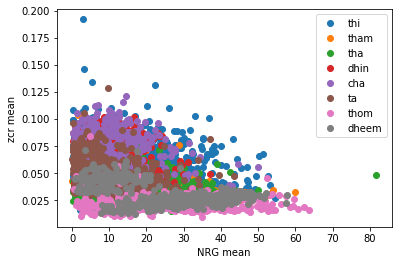

In [0]:
featureList = ['specFlatness','specCentroid','NRG','zcr']
for i in range(4):
    for j in range(i+1,4):
        stroke1 = 'thi'
        stroke2 = 'tham'
        stroke3 = 'tha'
        stroke4 = 'dhin'
        stroke5 = 'cha'
        stroke6 = 'ta'
        stroke7 = 'thom'
        stroke8 = 'dheem'
        plt.plot(globalFeatsData[stroke1]['mean_' + featureList[i]],globalFeatsData[stroke1]['mean_' + featureList[j]],'o',label = stroke1)
        plt.plot(globalFeatsData[stroke2]['mean_' + featureList[i]],globalFeatsData[stroke2]['mean_' + featureList[j]],'o',label = stroke2)
        plt.plot(globalFeatsData[stroke3]['mean_' + featureList[i]],globalFeatsData[stroke3]['mean_' + featureList[j]],'o',label = stroke3)
        plt.plot(globalFeatsData[stroke4]['mean_' + featureList[i]],globalFeatsData[stroke4]['mean_' + featureList[j]],'o',label = stroke4)
        plt.plot(globalFeatsData[stroke5]['mean_' + featureList[i]],globalFeatsData[stroke5]['mean_' + featureList[j]],'o',label = stroke5)
        plt.plot(globalFeatsData[stroke6]['mean_' + featureList[i]],globalFeatsData[stroke6]['mean_' + featureList[j]],'o',label = stroke6)
        plt.plot(globalFeatsData[stroke7]['mean_' + featureList[i]],globalFeatsData[stroke7]['mean_' + featureList[j]],'o',label = stroke7)
        plt.plot(globalFeatsData[stroke8]['mean_' + featureList[i]],globalFeatsData[stroke8]['mean_' + featureList[j]],'o',label = stroke8)
        plt.legend(loc = 'best')
        plt.xlabel(featureList[i] + ' mean')
        plt.ylabel(featureList[j] + ' mean')
        plt.show()

**Discussion:** distinctiveness of features, feature selection, dimensionality reduction

For similar examples from other course material see: 
1) https://github.com/stevetjoa/stanford-mir/blob/gh-pages/basic_feature_extraction.ipynb , 
2) https://github.com/stevetjoa/stanford-mir/blob/gh-pages/spectral_features.ipynb

### Homework:
Use other queries (musical instrument sounds) to collect small sound datasets from Freesound and spot statistical features where the classes can be easily separated. Explain why those features are suited for such a task based on acoustic characteristics of the type of sounds available in your dataset.